In [8]:
from math import sqrt

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from tqdm import tqdm

In [4]:
dataset = pd.read_csv('data/train.tsv', sep='\t', header=0)
dataset['category_name'] = dataset['category_name'].fillna('Other').astype(str)
dataset['brand_name'] = dataset['brand_name'].fillna('missing').astype(str)
dataset['shipping'] = dataset['shipping']
dataset['item_condition_id'] = dataset['item_condition_id']
dataset['item_description'] = dataset['item_description'].fillna('None')

In [5]:
# split category into general, sub1, and sub2
categories = list(dataset['category_name'])

gencat_list = []
subcat1_list = []
subcat2_list = []

for cat in categories:
    cats = cat.split("/")
    cats[0] = cats[0].replace(' ', '')
    cats[0] = cats[0].replace('&', '_')
    if len(cats) > 1:
        cats[1] = cats[1].replace(' ', '')
        cats[1] = cats[1].replace('&', '_')
    if len(cats) > 2:
        cats[2] = cats[2].replace(' ', '')
        cats[2] = cats[2].replace('&', '_')
    gencat_list.append(cats[0].strip())
    subcat1_list.append(cats[1].strip() if len(cats) > 1 else "Other")
    subcat2_list.append(cats[2].strip() if len(cats) > 2 else "Other")

dataset["general_category"] = gencat_list
dataset["subcategory_1"] = subcat1_list
dataset["subcategory_2"] = subcat2_list
dataset.drop('category_name', axis=1, inplace=True)

In [6]:
X = dataset.loc[:, dataset.columns != 'price']
Y = np.log1p(dataset['price'])

# 80% training data, 20% test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [17]:
# % % time

preprocessor = CountVectorizer().build_preprocessor()


def build_field_preprocessor(field):
    field_idx = list(X_train.columns).index(field)
    return lambda x: preprocessor(x[field_idx])  # this preprocesses like stripping accents, etc.


class OneHotVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, column):
    # def __init__(self, preprocessor):
        self.column = column

    def fit(self, X, y=None):
        self.enc = OneHotEncoder(sparse=False)
        self.enc.fit(X[:,self.column].reshape(-1, 1))
        return self

    def transform(self, X):
        return self.enc.transform(X[:,self.column].reshape(-1, 1))



vectorizer = FeatureUnion([
    *[(field, CountVectorizer(
        lowercase=False,
        binary=True,
        preprocessor=build_field_preprocessor(field)
    )) for field in ['brand_name', 'general_category', 'subcategory_1', 'subcategory_2']],

    ('name', TfidfVectorizer(
        ngram_range=(1, 3),
        min_df=3,
        max_features=250_000,
        preprocessor=build_field_preprocessor('name')
    )),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        min_df=5,
        max_features=500_000,
        preprocessor=build_field_preprocessor('item_description')
    )),

    ('item_condition_id', OneHotVectorizer(
        # preprocessor=build_field_preprocessor('item_condition_id')
        column = list(X_train.columns).index('item_condition_id')
    )),
    # OneHotEncoder(
    #     sparse=False
    # )
])

X_train_transformed = vectorizer.fit_transform(X_train.values[:100])
X_test_transformed = vectorizer.transform(X_test.values[:100])

In [18]:
X_train_transformed

<100x301 sparse matrix of type '<class 'numpy.float64'>'
	with 1437 stored elements in Compressed Sparse Row format>

In [32]:
# TODO: Use this transformed data to train, and then use the vectorizer in eli5
# OneHotEncoder().fit(X_train['item_condition_id'].values)
# from sklearn.preprocessing import MultiLabelBinarizer
# MultiLabelBinarizer().fit_transform(X_train['item_condition_id'].values[:10])
xxx = X_train['item_condition_id'].values[:10].reshape(-1, 1)
print(xxx)
# encoded = OneHotEncoder(sparse=False).fit_transform(X_train['item_condition_id'].values[:10].reshape(-1, 1))
encoded = OneHotEncoder(sparse=False).fit_transform(xxx)
print(encoded)

# X_train['item_condition_id'].values[:10].reshape(-1, 1)

[[3]
 [3]
 [1]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]]
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [18]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# define example
data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print('integer encoded: ', integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(-1, 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

['cold' 'cold' 'warm' 'cold' 'hot' 'hot' 'warm' 'cold' 'warm' 'hot']
integer encoded:  [0 0 2 0 1 1 2 0 2 1]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
['cold']


In [6]:
# one hot encode categorical features that are not already numbers

def one_hot_categorical(train, test):
    vectorizer = CountVectorizer(lowercase=False, binary=True)
    onehot_train = vectorizer.fit_transform(train.values)
    onehot_test = vectorizer.transform(test.values)
    return onehot_train, onehot_test


onehot_train_brand, onehot_test_brand = one_hot_categorical(X_train['brand_name'], X_test['brand_name'])
onehot_train_gencat, onehot_test_gencat = one_hot_categorical(X_train['general_category'], X_test['general_category'])
onehot_train_subcat1, onehot_test_subcat1 = one_hot_categorical(X_train['subcategory_1'], X_test['subcategory_1'])
onehot_train_subcat2, onehot_test_subcat2 = one_hot_categorical(X_train['subcategory_2'], X_test['subcategory_2'])

In [7]:
# Use tfidf for text-based features

def tfidf_text(train, test, min_df, max_features):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=min_df, max_features=max_features)
    tfidf_train = vectorizer.fit_transform(train.values)
    tfidf_test = vectorizer.transform(test.values)
    return tfidf_train, tfidf_test


tfidf_train_name, tfidf_test_name = tfidf_text(X_train['name'], X_test['name'], 3, 250000)
tfidf_train_description, tfidf_test_description = tfidf_text(X_train['item_description'], X_test['item_description'], 5,
                                                             500000)

In [8]:
% % time

# Storing categorical features that are already numbers to sparse matrix

X_train_cat = csr_matrix(pd.get_dummies(X_train[['item_condition_id', 'shipping']], sparse=True).values)

X_test_cat = csr_matrix(pd.get_dummies(X_test[['item_condition_id', 'shipping']], sparse=True).values)

CPU times: user 118 ms, sys: 124 ms, total: 243 ms
Wall time: 375 ms


In [9]:
print(X_train_cat.shape, X_test_cat.shape)

(1186028, 2) (296507, 2)


In [10]:
# stack all categorical and text sparse matrices
train_x = hstack((onehot_train_brand, onehot_train_gencat, onehot_train_subcat1, onehot_train_subcat2,
                  tfidf_train_name, tfidf_train_description, X_train_cat)).tocsr()
test_x = hstack((onehot_test_brand, onehot_test_gencat, onehot_test_subcat1, onehot_test_subcat2,
                 tfidf_test_name, tfidf_test_description, X_test_cat)).tocsr()

In [11]:
print(train_x.shape, test_x.shape)

(1186028, 755993) (296507, 755993)


100%|██████████| 9/9 [40:55<00:00, 272.89s/it]


RMSLE for alpha =  1 is 0.4474947261239424
RMSLE for alpha =  2 is 0.441945502299795
RMSLE for alpha =  3 is 0.44113430866202924
RMSLE for alpha =  3.5 is 0.44128635282016876
RMSLE for alpha =  4 is 0.44159142468265794
RMSLE for alpha =  4.5 is 0.44203240994961573
RMSLE for alpha =  5 is 0.44253122639412035
RMSLE for alpha =  6 is 0.4436106837725421
RMSLE for alpha =  7 is 0.4447336010054999


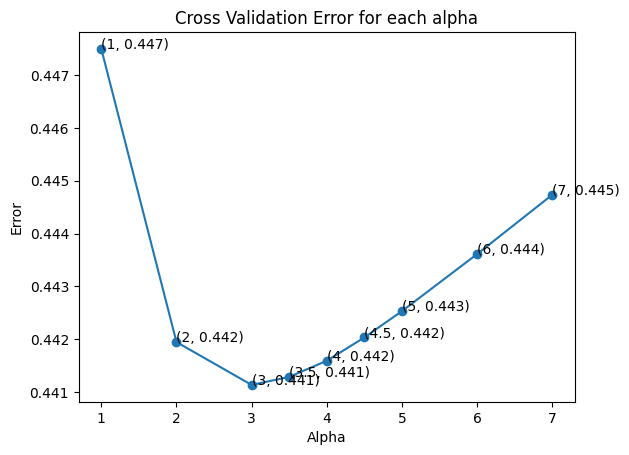

In [12]:
alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7]
test_rmsle_array = []
for i in tqdm(alpha):
    model = Ridge(solver="sparse_cg", random_state=42, alpha=i)
    model.fit(train_x, Y_train)
    preds_test = model.predict(test_x)
    test_rmsle_array.append(sqrt(mse(Y_test, preds_test)))

for i in range(len(test_rmsle_array)):
    print('RMSLE for alpha = ', alpha[i], 'is', test_rmsle_array[i])

best_alpha = np.argmin(test_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, test_rmsle_array)
ax.scatter(alpha, test_rmsle_array)
for i, txt in enumerate(np.round(test_rmsle_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], test_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [13]:
print("Best alpha: ", alpha[best_alpha])
model = Ridge(solver="sag", random_state=42, alpha=alpha[best_alpha])
model.fit(train_x, Y_train)
ridge_preds_train = model.predict(train_x)
ridge_preds_test = model.predict(test_x)

print('Train RMSLE:', sqrt(mse(Y_train, ridge_preds_train)))

ridge_rmsle = sqrt(mse(Y_test, ridge_preds_test))
print("Cross validation RMSLE: ", ridge_rmsle)

Best alpha:  3


/Users/marc/opt/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:830: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Train RMSLE: 0.3799885770404893
Cross validation RMSLE:  0.4410885811609205


In [18]:
X_train

,train_id,name,item_condition_id,brand_name,shipping,item_description,general_category,subcategory_1,subcategory_2
901879,901879,Black Nike Cortez Size 4,2,Nike,1,Size 4. My baby wore once before she was reall...,Kids,Boys2T-5T,Shoes
984774,984774,HP Pavilion DV5000 DV6000 DV8000 DV9000,3,HP,1,HP Pavilion DV5000 DV6000 DV8000 DV9000 Ac Ada...,Other,Other,Other
1059057,1059057,New 24pc Cake Decorating Kit,1,missing,1,New Cake Decorating Set - With 24 pcs Icing Ti...,Home,Kitchen_Dining,Bakeware
122771,122771,Marc by marc jacobs,2,MARC BY MARC JACOBS,0,Authentic light brown pebble leather marc by m...,Women,Women'sAccessories,Wallets
293900,293900,Samsung s7 edge brand new,1,Samsung,1,"Brand new still in box, everything included. C...",Electronics,CellPhones_Accessories,CellPhones_Smartphones
...,...,...,...,...,...,...,...,...,...
359953,359953,"2 Jacket, 1 Shirt And Bottoms",3,missing,0,"USPA, IZOD, PERRY ELLIS, LEVI",Other,Other,Other
152400,152400,White maxi dress perfect for summer!,2,missing,0,Never been worn! So beautiful for summer night...,Women,Skirts,Maxi
963931,963931,Barcelona Messi Soccer Jersey 2018 (M),1,missing,1,Barcelona Messi Soccer Jersey Size: Medium 100...,Men,AthleticApparel,Jerseys
118024,118024,32 pcs Vander makeup brushes,1,missing,1,Package includes: 14 x The Specifications Eyes...,Beauty,Tools_Accessories,MakeupBrushes_Tools


In [ ]:
eli5.show_weights(model, vec=)